<a href="https://colab.research.google.com/github/sofiaElenaHopartean/NLP_recipes/blob/main/recipes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup and imports

In [4]:
# !python -m spacy download en_core_web_md
# !python -m spacy download en_core_web_sm

In [5]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [6]:
import pandas as pd
import numpy as np
import csv
from spacy import displacy
from spacy.util import minibatch, compounding

import matplotlib.pyplot as plt
%matplotlib inline

### EDA

In [10]:
recipes_df = pd.read_csv("drive/MyDrive/recipes.csv", delimiter=";")
recipes_df.head(3)

,Recipe Name,Review Count,Recipe Photo,Author,Prepare Time,Cook Time,Total Time,Ingredients,Directions,RecipeID
0,Golden Crescent Rolls Recipe,304,https://images.media-allrecipes.com/userphotos...,Mike A.,25 m,15 m,3 h 10 m,"yeast,water,white sugar,salt,egg,butter,flour,...","Dissolve yeast in warm water.**Stir in sugar, ...",7000
1,Poppy Seed Bread with Glaze Recipe,137,https://images.media-allrecipes.com/userphotos...,Christina Jun,15 m,1 h,1 h 20 m,"flour,salt,baking powder,poppy,butter,vegetabl...",'Preheat oven to 350 degrees F (175 degrees C)...,7001
2,Applesauce Bread I Recipe,124,https://images.media-allrecipes.com/userphotos...,GAF55,10 m,1 h 20 m,1 h 30 m,"flour,egg,white sugar,vegetable oil,applesauce...",Preheat oven to 350 degrees F (175 degrees C)....,7003


In [11]:
recipes_df.describe()

,RecipeID
count,12351.000000
mean,16149.829326
std,5745.770833
min,7000.000000
25%,11150.500000
50%,15564.000000
75%,20889.500000
max,27546.000000


In [12]:
recipes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12351 entries, 0 to 12350
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Recipe Name   12351 non-null  object
 1   Review Count  12351 non-null  object
 2   Recipe Photo  12351 non-null  object
 3   Author        12351 non-null  object
 4   Prepare Time  12351 non-null  object
 5   Cook Time     12351 non-null  object
 6   Total Time    12351 non-null  object
 7   Ingredients   12351 non-null  object
 8   Directions    12345 non-null  object
 9   RecipeID      12351 non-null  int64 
dtypes: int64(1), object(9)
memory usage: 965.0+ KB


In [13]:
recipes_df.isnull().sum()

Recipe Name     0
Review Count    0
Recipe Photo    0
Author          0
Prepare Time    0
Cook Time       0
Total Time      0
Ingredients     0
Directions      6
RecipeID        0
dtype: int64

In [14]:
recipes_df[recipes_df['Directions'].isna()]
# recipes_df[recipes_df.isna().any(axis=1)]

,Recipe Name,Review Count,Recipe Photo,Author,Prepare Time,Cook Time,Total Time,Ingredients,Directions,RecipeID
292,Sunshine Cake Recipe,9,https://images.media-allrecipes.com/userphotos...,Helga,X,X,X,"egg,white sugar,water,flour,baking powder,salt...",NaN,7378
3818,Cherry Pie I Recipe,11,https://images.media-allrecipes.com/userphotos...,Cali,X,X,X,"vanilla,gelatin,water,cherry,white sugar,corns...",NaN,12251
4320,Quick Clam Chowder Recipe,42,https://images.media-allrecipes.com/userphotos...,Lew Sweet,X,X,X,"england,potato,celery,clam,onion,celery,margar...",NaN,12981
6238,Hot Clam Dip II Recipe,30,https://images.media-allrecipes.com/userphotos...,lara,X,X,X,"bread,cream cheese,onion,beer,worcestershire s...",NaN,15648
9330,Chocolate Sausage (Salame di Cioccolato) Recipe,2,https://images.media-allrecipes.com/images/795...,Manuela,X,X,X,"white sugar,egg,egg,butter,cocoa powder,cookie...",NaN,21002
10676,Oatmeal Kiss Cookies Recipe,6,https://images.media-allrecipes.com/userphotos...,HersheysKitchens.com,X,X,X,"chocolate,butter,shortening,white sugar,brown ...",NaN,24031


In [16]:
recipes_df_small = recipes_df[~recipes_df['Directions'].isna()][["Directions", "Ingredients"]]

In [18]:
recipes_df_small.shape

(12345, 2)

In [19]:
recipes_df_small.head()

,Directions,Ingredients
0,"Dissolve yeast in warm water.**Stir in sugar, ...","yeast,water,white sugar,salt,egg,butter,flour,..."
1,'Preheat oven to 350 degrees F (175 degrees C)...,"flour,salt,baking powder,poppy,butter,vegetabl..."
2,Preheat oven to 350 degrees F (175 degrees C)....,"flour,egg,white sugar,vegetable oil,applesauce..."
3,Preheat oven to 350 degrees F (175 degrees C)....,"flour,baking powder,baking soda,salt,cinnamon,..."
4,Mix oats with buttermilk. Let stand for 1/2 h...,"oat,buttermilk,vegetable oil,egg,brown sugar,f..."


In [24]:
directions_lengths = [ sum(not chr.isspace() for chr in str) for str in recipes_df_small["Directions"]]
ingredients_lengths = [ sum(not chr.isspace() for chr in str) for str in recipes_df_small['Ingredients']]

In [25]:
print(directions_lengths[:10])
print(ingredients_lengths[:10])

[548, 446, 269, 293, 261, 459, 583, 139, 323, 277]
[51, 124, 94, 107, 77, 59, 72, 75, 97, 101]


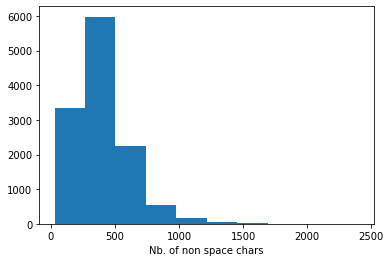

In [31]:
plt.hist(directions_lengths)
plt.xlabel("Nb. of non space chars")
plt.show()

In [32]:
small_directions = [len_ for len_ in directions_lengths if len_ <=10]
small_directions

[]

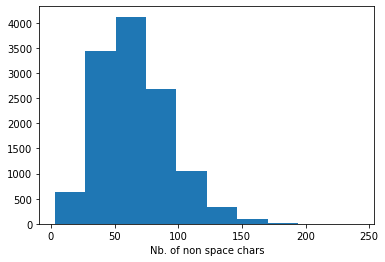

nb of non space chars: [(64, 5), (728, 4), (745, 4), (915, 10), (1009, 9), (3530, 9), (4885, 7), (4925, 8), (5073, 6), (5076, 10), (6829, 6), (7202, 10), (7817, 4), (8244, 10), (8552, 3), (8804, 10), (9091, 3), (10123, 7), (10177, 5), (11148, 4)]


In [36]:
plt.hist(ingredients_lengths)
plt.xlabel("Nb. of non space chars")
plt.show()
small_ingreds = [(i, ingredients_lengths[i]) 
        for i in range(len(ingredients_lengths)) 
        if ingredients_lengths[i] <=10]
print("nb of non space chars:", small_ingreds)

In [40]:
recipes_df_small.iloc[[i for i, _ in small_ingreds]]

,Directions,Ingredients
64,Thaw bread dough.**Preheat oven to 375 degrees...,bread
729,Preheat oven to 375 degrees F (190 degrees C)....,cake
746,Start with a cooled 9-inch square cake. From o...,cake
916,"In a large bowl, combine cake mix, peaches and...","cake,peach"
1010,'Prepare the cake according to package instruc...,"cake,side"
3531,"'Heap the flour, and make a well in it. Break...","flour,egg"
4888,Preheat oven to 300 degrees F (150 degrees C)....,pumpkin
4928,Preheat oven to 275 degrees F. (135 degrees C)...,"ham,cola"
5076,"Cut each tomato in half through the middle, n...",cherry
5079,Preheat the oven to 500 degrees F (260 degrees...,bell pepper
